<a href="https://colab.research.google.com/github/hate-speech-classification/abusive-level-classification/blob/kfold/abusive_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Init
"""
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
"""
Read data from csv (url from github)
"""
url_train_data = 'https://raw.githubusercontent.com/amandacurry/convabuse/main/2_splits/ConvAbuseEMNLPtrain.csv'
df = pd.read_csv(url_train_data)

"""
Create new column labels
"""
def categorise(row):
  if row['Annotator1_is_abuse.1'] == '1':
    return 'Not abusive'
  elif row['Annotator1_is_abuse.0'] == '1':
    return "Ambiguous"
  elif row['Annotator1_is_abuse.-1'] == '1':
    return "Mildly abusive"
  elif row['Annotator1_is_abuse.-2'] == '1':
    return "Strongly abusive"
  elif row['Annotator1_is_abuse.-3'] == '1':
    return "Very strongly abusive"

my_tags = ['Not abusive', 'Ambiguous', 'Midly abusive', 'Strongly abusive', 'Very strongly abusive']
df['abusive_level'] = df.apply(lambda row: categorise(row), axis=1) 
df = df[pd.notnull(df['abusive_level'])]
# df.tail(10)

In [12]:
"""
Clean text (user column)
"""
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['user'] = df['user'].apply(clean_text)
data = df[['user','abusive_level']]
X = data.user
Y = data.abusive_level
# kFold
kfold = KFold(n_splits=10, random_state=100, shuffle=True)

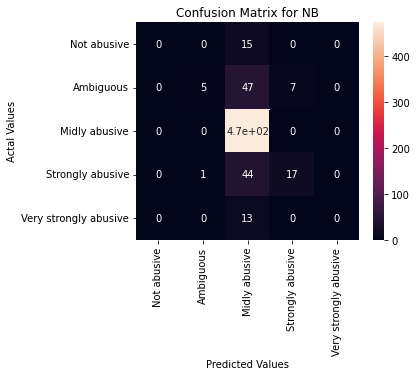

Accuracy: 78.64%


In [16]:
"""
Naive Bayes Classifier 
Idea: text is categorized based on TF*IDF (term frequency * inverse data frequency)
"""

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns
import matplotlib.pyplot as plt

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
model = nb.fit(X, Y)
y_pred = model.predict(X)
cm = confusion_matrix(Y, y_pred)
cm_df = pd.DataFrame(cm, index = ['Not abusive', 'Ambiguous', 'Midly abusive', 'Strongly abusive', 'Very strongly abusive'], columns = ['Not abusive', 'Ambiguous', 'Midly abusive', 'Strongly abusive', 'Very strongly abusive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix for NB')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
# %%time
from sklearn.metrics import classification_report
# y_pred = nb.predict(X_test)
results_kfold = model_selection.cross_val_score(nb, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 
# print('accuracy %s' % accuracy_score(y_pred, y_test))

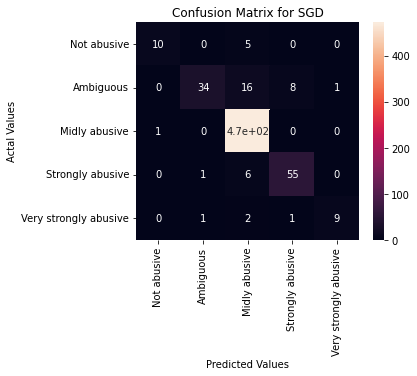

Accuracy: 82.01%


In [17]:
"""
Linear Support Vector Machine
Idea: text is categorized based on TF*IDF (term frequency * inverse data frequency)
"""

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
model = sgd.fit(X, Y)
y_pred = model.predict(X)
cm = confusion_matrix(Y, y_pred)
cm_df = pd.DataFrame(cm, index = ['Not abusive', 'Ambiguous', 'Midly abusive', 'Strongly abusive', 'Very strongly abusive'], columns = ['Not abusive', 'Ambiguous', 'Midly abusive', 'Strongly abusive', 'Very strongly abusive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix for SGD')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# %%time
results_kfold = model_selection.cross_val_score(sgd, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 
# y_pred = sgd.predict(X_test)

# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred,target_names=my_tags,zero_division=1))

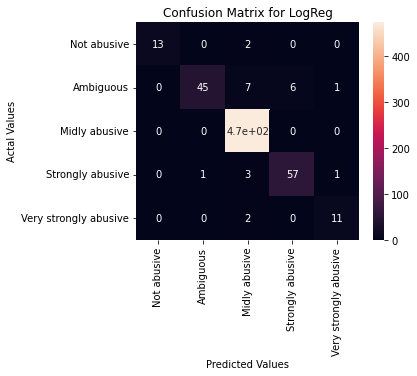

Accuracy: 79.92%


In [19]:
"""
Logistic Regression
Idea: text is categorized based on TF*IDF (term frequency * inverse data frequency)
"""


from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=100000)),
               ])
model = logreg.fit(X, Y)
y_pred = model.predict(X)
cm = confusion_matrix(Y, y_pred)
cm_df = pd.DataFrame(cm, index = ['Not abusive', 'Ambiguous', 'Midly abusive', 'Strongly abusive', 'Very strongly abusive'], columns = ['Not abusive', 'Ambiguous', 'Midly abusive', 'Strongly abusive', 'Very strongly abusive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix for LogReg')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# %%time
results_kfold = model_selection.cross_val_score(logreg, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 